# 6. Linear Regression with Multiple Regressors

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
df = pd.read_excel("data/replication/Replication Data/caschool.xlsx")
df.head()

F:\miniconda3\envs\py\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,Observation Number,dist_cod,county,district,gr_span,enrl_tot,teachers,calw_pct,meal_pct,computer,testscr,comp_stu,expn_stu,str,avginc,el_pct,read_scr,math_scr
0,1,75119,Alameda,Sunol Glen Unified,KK-08,195,10.900000,0.510200,2.040800,67,690.799988,0.343590,6384.911133,17.889910,22.690001,0.000000,691.599976,690.000000
1,2,61499,Butte,Manzanita Elementary,KK-08,240,11.150000,15.416700,47.916698,101,661.200012,0.420833,5099.380859,21.524664,9.824000,4.583333,660.500000,661.900024
2,3,61549,Butte,Thermalito Union Elementary,KK-08,1550,82.900002,55.032299,76.322601,169,643.599976,0.109032,5501.954590,18.697226,8.978000,30.000002,636.299988,650.900024
3,4,61457,Butte,Golden Feather Union Elementary,KK-08,243,14.000000,36.475399,77.049202,85,647.700012,0.349794,7101.831055,17.357143,8.978000,0.000000,651.900024,643.500000
4,5,61523,Butte,Palermo Union Elementary,KK-08,1335,71.500000,33.108601,78.427002,171,640.849976,0.128090,5235.987793,18.671329,9.080333,13.857677,641.799988,639.900024


## Omitted Variable Bias

In [3]:
df.columns

Index(['Observation Number', 'dist_cod', 'county', 'district', 'gr_span',
       'enrl_tot', 'teachers', 'calw_pct', 'meal_pct', 'computer', 'testscr',
       'comp_stu', 'expn_stu', 'str', 'avginc', 'el_pct', 'read_scr',
       'math_scr'],
      dtype='object')

Students who are still learning English might perform worse on standardized tests than
native English speakers.

In [4]:
df['str'].corr(df["el_pct"])

np.float64(0.18764236785449276)

<Axes: xlabel='str', ylabel='el_pct'>

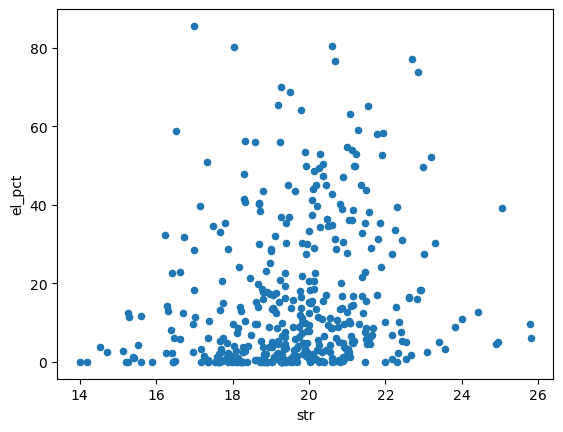

In [5]:
df.plot('str','el_pct', kind = 'scatter')

This small but positive correlation suggests that districts with more
English learners tend to have a higher student–teacher ratio (larger classes)

It is plausible that students who are still learning English will do
worse on standardized tests than native English speakers

**Percentage of English learners**: 
correlated with student teacher ratio ✅  
determinant of test score ✅  
$ \therefore$ omitting it leads to ommited variable bias

**Time of day of the test**:   
uncorrelated with student teacher ratio ❌  
determinant of test score ✅    
$ \therefore$ omitting it does not lead to ommited variable bias

**Parking lot space per pupil**: 
(the area of the teacher parking lot divided by the number of students)  
  
correlated with student teacher ratio ✅  
determinant of test score ❌  
$ \therefore$ omitting it does not lead to ommited variable bias

In [6]:
df['el_pct']

0       0.000000
1       4.583333
2      30.000002
3       0.000000
4      13.857677
         ...    
415     5.995935
416     4.726101
417    24.263039
418     2.970297
419     5.005624
Name: el_pct, Length: 420, dtype: float64

### Addressing ommited variable bias by dividing data into groups

In [7]:
bins = [0, 1.9, 8.8, 23, float('inf')]
labels = ['< 1.9', '1.9-8.8', '8.8-23', '> 23']

df['el_pct_category'] = pd.cut(df['el_pct'], bins=bins, labels=labels, right = False)
df.head()

,Observation Number,dist_cod,county,district,gr_span,enrl_tot,teachers,calw_pct,meal_pct,computer,testscr,comp_stu,expn_stu,str,avginc,el_pct,read_scr,math_scr,el_pct_category
0,1,75119,Alameda,Sunol Glen Unified,KK-08,195,10.900000,0.510200,2.040800,67,690.799988,0.343590,6384.911133,17.889910,22.690001,0.000000,691.599976,690.000000,< 1.9
1,2,61499,Butte,Manzanita Elementary,KK-08,240,11.150000,15.416700,47.916698,101,661.200012,0.420833,5099.380859,21.524664,9.824000,4.583333,660.500000,661.900024,1.9-8.8
2,3,61549,Butte,Thermalito Union Elementary,KK-08,1550,82.900002,55.032299,76.322601,169,643.599976,0.109032,5501.954590,18.697226,8.978000,30.000002,636.299988,650.900024,> 23
3,4,61457,Butte,Golden Feather Union Elementary,KK-08,243,14.000000,36.475399,77.049202,85,647.700012,0.349794,7101.831055,17.357143,8.978000,0.000000,651.900024,643.500000,< 1.9
4,5,61523,Butte,Palermo Union Elementary,KK-08,1335,71.500000,33.108601,78.427002,171,640.849976,0.128090,5235.987793,18.671329,9.080333,13.857677,641.799988,639.900024,8.8-23


In [8]:
df['D'] = (df['str'] < 20).astype(int)
df['D'] = df['D'].map({0: '>= 20', 1: '< 20'})
df.head()

,Observation Number,dist_cod,county,district,gr_span,enrl_tot,teachers,calw_pct,meal_pct,computer,testscr,comp_stu,expn_stu,str,avginc,el_pct,read_scr,math_scr,el_pct_category,D
0,1,75119,Alameda,Sunol Glen Unified,KK-08,195,10.900000,0.510200,2.040800,67,690.799988,0.343590,6384.911133,17.889910,22.690001,0.000000,691.599976,690.000000,< 1.9,< 20
1,2,61499,Butte,Manzanita Elementary,KK-08,240,11.150000,15.416700,47.916698,101,661.200012,0.420833,5099.380859,21.524664,9.824000,4.583333,660.500000,661.900024,1.9-8.8,>= 20
2,3,61549,Butte,Thermalito Union Elementary,KK-08,1550,82.900002,55.032299,76.322601,169,643.599976,0.109032,5501.954590,18.697226,8.978000,30.000002,636.299988,650.900024,> 23,< 20
3,4,61457,Butte,Golden Feather Union Elementary,KK-08,243,14.000000,36.475399,77.049202,85,647.700012,0.349794,7101.831055,17.357143,8.978000,0.000000,651.900024,643.500000,< 1.9,< 20
4,5,61523,Butte,Palermo Union Elementary,KK-08,1335,71.500000,33.108601,78.427002,171,640.849976,0.128090,5235.987793,18.671329,9.080333,13.857677,641.799988,639.900024,8.8-23,< 20


In [9]:
grouped = df.groupby(['D', 'el_pct_category'], observed=True)

In [10]:
grouped.agg(
    avg_test_score=('testscr', 'mean'),
    n=('testscr', 'size')
).reset_index()

,D,el_pct_category,avg_test_score,n
0,< 20,< 1.9,664.470391,76
1,< 20,1.9-8.8,665.157029,64
2,< 20,8.8-23,654.882406,54
3,< 20,> 23,636.730687,44
4,>= 20,< 1.9,665.370377,27
5,>= 20,1.9-8.8,661.828405,44
6,>= 20,8.8-23,649.713007,50
7,>= 20,> 23,634.836888,61


In [11]:
mean_crosstab = pd.crosstab(df['D'], df['el_pct_category'],
                            values=df['testscr'], aggfunc='mean')
mean_crosstab

el_pct_category,< 1.9,1.9-8.8,8.8-23,> 23
D,,,,
< 20,664.470391,665.157029,654.882406,636.730687
>= 20,665.370377,661.828405,649.713007,634.836888


In [12]:
count_crosstab = pd.crosstab(df['D'], df['el_pct_category'])
count_crosstab

el_pct_category,< 1.9,1.9-8.8,8.8-23,> 23
D,,,,
< 20,76,64,54,44
>= 20,27,44,50,61


In [13]:
averageScoreSmallRatio = df[df["D"] == '< 20']['testscr'].mean()
averageScoreSmallRatio

np.float64(657.3512591193704)

In [14]:
averageScorelargeRatio = df[df["D"] == '>= 20']['testscr'].mean()
averageScorelargeRatio

np.float64(649.9788489708534)

In [15]:
averageScoreSmallRatio - averageScorelargeRatio

np.float64(7.3724101485170195)

In [16]:
from scipy import stats
t_stat, p_value = stats.ttest_ind(df[df["D"] == '>= 20']['testscr'],
                                   df[df["D"] == '< 20']['testscr'], equal_var = False)
t_stat, p_value

(np.float64(-4.042581848666498), np.float64(6.332554425244588e-05))

null hypothesis that the mean test score is the same in the two
groups is rejected at the 1% significance level

#### across all districts, 
those with a low student–teacher ratio have, on average, a test score 7.4 points higher than those with a high student–teacher ratio. The t-statistic of 4.04 indicates that this difference is statistically significant.

#### Differences by Percentage of English Learners

<= 1.9%:

Average test score for districts with low student–teacher ratio: 664.5  
Average test score for districts with high student–teacher ratio: 665.4  
Difference in test scores: -0.9  
t-statistic: -0.30

1.9–8.8%:

Average test score for districts with low student–teacher ratio: 665.2   
Average test score for districts with high student–teacher ratio: 661.8  
Difference in test scores: 3.3  
t-statistic: 1.13

8.8–23.0%:

Average test score for districts with low student–teacher ratio: 654.9  
Average test score for districts with high student–teacher ratio: 649.7  
Difference in test scores: 5.2  
t-statistic: 1.72  

 23.0%:

Average test score for districts with low student–teacher ratio: 636.7  
Average test score for districts with high student–teacher ratio: 634.8  
Difference in test scores: 1.9  
t-statistic: 0.68

Overall Effect: The overall difference in test scores suggests that districts with low student–teacher ratios tend to have higher test scores.  

By Quartile: When breaking down by the percentage of English learners, the differences in test scores are smaller and less consistent. This suggests that the effect of student–teacher ratio on test scores is influenced by the percentage of English learners in the district.

#### Why the Differences?

Districts with more English learners tend to have both higher student–teacher ratios and lower test scores.  
The large overall difference in test scores (7.4 points) is partly due to the fact that districts with fewer English learners (who generally have higher test scores) also tend to have lower student–teacher ratios.  
When you control for the percentage of English learners, the differences in test scores between low and high student–teacher ratio districts are smaller. This indicates that the percentage of English learners is an important factor that affects test scores.

## Multiple Regression

In [49]:
model = smf.ols("testscr ~ str", data = df).fit(cov_type='HC2')
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                testscr   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     19.13
Date:                Wed, 10 Jul 2024   Prob (F-statistic):           1.55e-05
Time:                        14:34:50   Log-Likelihood:                -1822.2
No. Observations:                 420   AIC:                             3648.
Df Residuals:                     418   BIC:                             3657.
Df Model:                           1                                         
Covariance Type:                  HC2                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    698.9330     10.400     67.206      0.0

In [18]:
model.rsquared

np.float64(0.051240095079614356)

Student Teacher Ratio explains only 5% of the variation in test scores

In [48]:
model2 = smf.ols("testscr ~ str + el_pct", data = df).fit(cov_type='HC2')
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                testscr   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.424
Method:                 Least Squares   F-statistic:                     222.8
Date:                Wed, 10 Jul 2024   Prob (F-statistic):           1.56e-66
Time:                        14:34:39   Log-Likelihood:                -1716.6
No. Observations:                 420   AIC:                             3439.
Df Residuals:                     417   BIC:                             3451.
Df Model:                           2                                         
Covariance Type:                  HC2                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    686.0322      8.754     78.365      0.0

coefficient of str became half (-1.10 vs -2.28) cuz it controls for english percentage

among
schools within the same quartile of percentage of English learners, the difference in test
scores between schools with a high vs. a low student–teacher ratio is less than the difference if one does not hold constant the percentage of English learners.

In [20]:
math.sqrt(model2.ssr/(model2.nobs - 3))

14.4644849557101

standard error decreased, predictions are more precise

In [21]:
model2.rsquared

np.float64(0.4264313614327716)

when EL_pct is added to the regression, 42.6% of the variation in test scores is explained

In [22]:
model2.rsquared_adj

np.float64(0.4236804327106266)

n is large and only two regressors appear, difference between $R^2$ and $\bar{R}^2$ is small

## Multicollinearity

### Perfect Multicollinearity

In [23]:
model2 = smf.ols("testscr ~ str + str", data = df).fit(cov_type='HC2')
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                testscr   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     19.13
Date:                Wed, 10 Jul 2024   Prob (F-statistic):           1.55e-05
Time:                        14:14:50   Log-Likelihood:                -1822.2
No. Observations:                 420   AIC:                             3648.
Df Residuals:                     418   BIC:                             3657.
Df Model:                           1                                         
Covariance Type:                  HC2                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    698.9330     10.400     67.206      0.0

#### fraction and percentage

In [24]:
df['fracel'] = df['el_pct']/100
df.head(1)

,Observation Number,dist_cod,county,district,gr_span,enrl_tot,teachers,calw_pct,meal_pct,computer,...,comp_stu,expn_stu,str,avginc,el_pct,read_scr,math_scr,el_pct_category,D,fracel
0,1,75119,Alameda,Sunol Glen Unified,KK-08,195,10.9,0.5102,2.0408,67,...,0.34359,6384.911133,17.88991,22.690001,0.0,691.599976,690.0,< 1.9,< 20,0.0


In [25]:
model3 = smf.ols("testscr ~ str + el_pct + fracel", data = df).fit(cov_type='HC2')
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:                testscr   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.424
Method:                 Least Squares   F-statistic:                     222.8
Date:                Wed, 10 Jul 2024   Prob (F-statistic):           1.56e-66
Time:                        14:14:50   Log-Likelihood:                -1716.6
No. Observations:                 420   AIC:                             3439.
Df Residuals:                     417   BIC:                             3451.
Df Model:                           2                                         
Covariance Type:                  HC2                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    686.0322      8.754     78.365      0.0

F:\miniconda3\envs\py\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2
  warnings.warn('covariance of constraints does not have full '


OLS fails because you are asking, What is the effect of a unit change in the
percentage of English learners, holding constant the fraction of English learners?   
Because the percentage of English learners and the fraction of English learners move
together in a perfect linear relationship, this question makes no sense, and OLS cannot answer it

#### wrong threshold for dummy variable

In [26]:
df['NVS'] = (df['str'] >= 12).astype(int)
df.head(1)

,Observation Number,dist_cod,county,district,gr_span,enrl_tot,teachers,calw_pct,meal_pct,computer,...,expn_stu,str,avginc,el_pct,read_scr,math_scr,el_pct_category,D,fracel,NVS
0,1,75119,Alameda,Sunol Glen Unified,KK-08,195,10.9,0.5102,2.0408,67,...,6384.911133,17.88991,22.690001,0.0,691.599976,690.0,< 1.9,< 20,0.0,1


In [27]:
df['NVS'].value_counts()

NVS
1    420
Name: count, dtype: int64

In [28]:
df['str'].describe()

count    420.000000
mean      19.640425
std        1.891812
min       14.000000
25%       18.582360
50%       19.723208
75%       20.871815
max       25.799999
Name: str, dtype: float64

Minimum str is 14, hence NVS is always 1, can be written as perfect linear relationship with the intercept

In [29]:
model4 = smf.ols("testscr ~ str + NVS ", data = df).fit(cov_type='HC2')
print(model4.summary())

                            OLS Regression Results                            
Dep. Variable:                testscr   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                 2.646e+05
Date:                Wed, 10 Jul 2024   Prob (F-statistic):               0.00
Time:                        14:14:50   Log-Likelihood:                -1822.2
No. Observations:                 420   AIC:                             3648.
Df Residuals:                     418   BIC:                             3657.
Df Model:                           1                                         
Covariance Type:                  HC2                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    349.4665      5.200     67.206      0.0

#### Complementary percentage

In [30]:
# percentage of english speakers
df['es_pct'] = 100 - df['el_pct']
df.head(1)

,Observation Number,dist_cod,county,district,gr_span,enrl_tot,teachers,calw_pct,meal_pct,computer,...,str,avginc,el_pct,read_scr,math_scr,el_pct_category,D,fracel,NVS,es_pct
0,1,75119,Alameda,Sunol Glen Unified,KK-08,195,10.9,0.5102,2.0408,67,...,17.88991,22.690001,0.0,691.599976,690.0,< 1.9,< 20,0.0,1,100.0


es_pct = 100 - el_pct = 100 * X0i - el_pct  
must exclude intercept or the complementary percentage

In [31]:
model5 = smf.ols("testscr ~ es_pct + el_pct ", data = df).fit(cov_type='HC2')
print(model5.summary())

                            OLS Regression Results                            
Dep. Variable:                testscr   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                 4.466e+05
Date:                Wed, 10 Jul 2024   Prob (F-statistic):               0.00
Time:                        14:14:51   Log-Likelihood:                -1720.7
No. Observations:                 420   AIC:                             3445.
Df Residuals:                     418   BIC:                             3454.
Df Model:                           1                                         
Covariance Type:                  HC2                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1262      0.000    548.782      0.0

#### Dummy variable trap

In [32]:
df['D'] = (df['str'] < 20).astype(int)
df = pd.get_dummies(df, columns=['D'], drop_first=False)
df.head(1)

,Observation Number,dist_cod,county,district,gr_span,enrl_tot,teachers,calw_pct,meal_pct,computer,...,avginc,el_pct,read_scr,math_scr,el_pct_category,fracel,NVS,es_pct,D_0,D_1
0,1,75119,Alameda,Sunol Glen Unified,KK-08,195,10.9,0.5102,2.0408,67,...,22.690001,0.0,691.599976,690.0,< 1.9,0.0,1,100.0,False,True


In [33]:
model6 = smf.ols("testscr ~ D_0 + D_1 ", data = df).fit(cov_type='HC2')
print(model6.summary())

                            OLS Regression Results                            
Dep. Variable:                testscr   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                 2.578e+05
Date:                Wed, 10 Jul 2024   Prob (F-statistic):               0.00
Time:                        14:14:51   Log-Likelihood:                -1825.4
No. Observations:                 420   AIC:                             3655.
Df Residuals:                     418   BIC:                             3663.
Df Model:                           1                                         
Covariance Type:                  HC2                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     435.7767      0.608    716.860      

Must have reference dummy variable 

In [34]:
model7 = smf.ols("testscr ~  D_1 ", data = df).fit(cov_type='HC2')
print(model7.summary())

                            OLS Regression Results                            
Dep. Variable:                testscr   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     16.34
Date:                Wed, 10 Jul 2024   Prob (F-statistic):           6.29e-05
Time:                        14:16:00   Log-Likelihood:                -1825.4
No. Observations:                 420   AIC:                             3655.
Df Residuals:                     418   BIC:                             3663.
Df Model:                           1                                         
Covariance Type:                  HC2                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     649.9788      1.323    491.151      

### Imperfect Multicollinearity

if $ X_1, X_2 $ are correlated, it  would be difficult to use these data to estimate the coefficient on $ X_1 $, holding constant $X_2$.

## Control Variables and Conditional Mean Independence

<Axes: xlabel='el_pct', ylabel='meal_pct'>

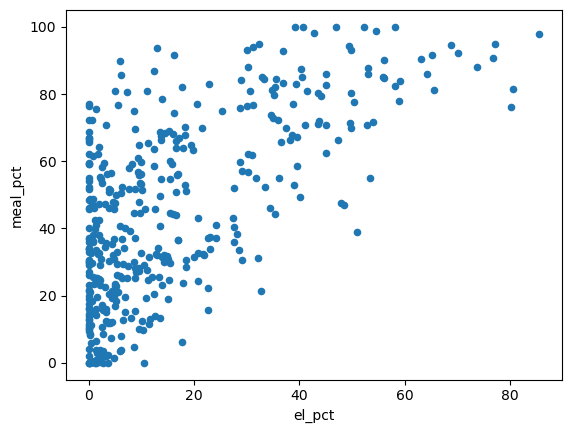

In [47]:
df.plot('el_pct', 'meal_pct', kind = 'scatter')

In [46]:
df['el_pct'].corr(df['meal_pct'])

np.float64(0.6530607156221082)

In [45]:
model7 = smf.ols("testscr ~  str + el_pct + meal_pct ", data = df).fit(cov_type='HC2')
print(model7.summary())

                            OLS Regression Results                            
Dep. Variable:                testscr   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     451.5
Date:                Wed, 10 Jul 2024   Prob (F-statistic):          2.13e-130
Time:                        14:28:24   Log-Likelihood:                -1520.5
No. Observations:                 420   AIC:                             3049.
Df Residuals:                     416   BIC:                             3065.
Df Model:                           3                                         
Covariance Type:                  HC2                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    700.1500      5.591    125.225      0.0

Coefficient of meal_pct is very large but does not have causal interpretation

Eliminating the reduced-price lunch program to reduce meal_pct to 0% is unlikely to boost test scores; it may even lower them by leaving students hungry.
It is a control variable not a regressor

We Include **control variables** to make regressors uncorrelated with error term

## Exercises

🚧 Under Construction